In [19]:
import numpy as np
import pandas as pd


import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch import nn, optim

from torchvision import transforms, models
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from scipy.io import loadmat
from PIL import Image
from tqdm import tqdm

import os, glob

import utils

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
print(os.listdir())
path_devkit = 'devkit/'
path_train_img = 'cars_train/'
path_test_img = 'cars_test/'

NUM_CLASSES = 196
IMG_SIZE = 224
RANDOM_SEED = 42

['.git', 'utils.py', '__pycache__', 'classifier.ipynb', 'cars_train.tgz', 'cars_train', 'test.ipynb', 'tmux-server-3267.log', 'cars_test.tgz', '.gitignore', '.ipynb_checkpoints', 'tmux-client-3265.log', 'devkit', 'checkpoint_epoch_20.pth', 'cars_test']


In [21]:
# lets store the information in the dataframe
mat = loadmat(path_devkit+'cars_meta.mat')

classes = []
for C in mat['class_names'][0]:
    classes.append(C[0])
classes = pd.DataFrame(classes,columns=['class_name'])

#blankidx = [''] * len(classes)
#classes.index = blankidx
classes.head()

,class_name
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [22]:
# lets store the test data in the dataFrame
mat = loadmat(path_devkit+'cars_test_annos.mat')
test_df = []
for row in mat['annotations'][0]:
    test_df.append([row[0][0][0],    # min x
                    row[1][0][0],    # max x
                    row[2][0][0],    # min y
                    row[3][0][0],    # max y
                    row[4][0]])      # file name

test_df = pd.DataFrame(test_df, columns=['min_x', 'min_y', 'max_x', 'max_y', 'file_name'])
test_df.head()

,min_x,min_y,max_x,max_y,file_name
0,30,52,246,147,00001.jpg
1,100,19,576,203,00002.jpg
2,51,105,968,659,00003.jpg
3,67,84,581,407,00004.jpg
4,140,151,593,339,00005.jpg


In [34]:
class CarDataset(Dataset):
    def __init__(self,df, classes, path_img, transforms=None, mode='train'):
        self.df = df
        self.classes = classes
        self.path_img = path_img
        self.transforms = transforms
        self.mode = mode
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name = self.df.iloc[index]['file_name']
        img = Image.open(self.path_img+img_name).convert('RGB')   # to create images with 3 channels
        # create one hot vector for the label
        #crop image
        img = img.crop((self.df.iloc[index]['min_x'],
                        self.df.iloc[index]['min_y'],
                        self.df.iloc[index]['max_x'],
                        self.df.iloc[index]['max_y']))
        
        if self.transforms is not None:
            img =  self.transforms(img)
            
            return img

In [35]:
transform_test = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])])

# test data generator
test_dataset = CarDataset(test_df, classes, path_test_img, transforms = transform_test, mode='test')
test_generator = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [36]:
images = next(iter(test_generator))
print('Image shape: {}\n'.format(images.shape))

Image shape: torch.Size([32, 3, 224, 224])



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1809.5, 905.5, -0.5)

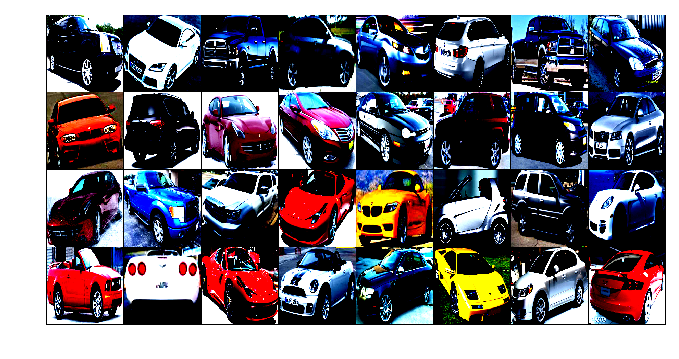

In [38]:
images = next(iter(test_generator))
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
grid = make_grid(images,nrow=8)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
#plt.title(labels)

In [40]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Sequential(nn.Linear(1024,NUM_CLASSES),
                                 nn.Softmax(dim=1))  

/home/dungeon_master/.conda/envs/downloader/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [41]:
if torch.cuda.is_available():
    model.load_state_dict(torch.load('checkpoint.pth'))
else:
    model.load_state_dict(torch.load('checkpoint.pth',map_location='cpu'))


In [42]:
use_gpu = False
if torch.cuda.is_available():
    model.cuda()
    use_gpu = True

In [49]:
#generate the output file.
img_list = os.listdir('cars_test')
data = []
for index,img in enumerate(sorted(glob.glob(path_test_img+'*'))):
    img_name = img.split('/')[1]
    img = Image.open(path_test_img+img_name).convert('RGB')
    #get the bounding box and crop image
    img = img.crop((test_df.iloc[index]['min_x'],
                    test_df.iloc[index]['min_y'],
                    test_df.iloc[index]['max_x'],
                    test_df.iloc[index]['max_y']))
    img = transform_test(img)
    img = img.unsqueeze(0)
    output = model(img)
    confidence, pred_y = torch.max(output,dim=1) 
    data.append([img_name, pred_y.item(), confidence.item()])
    if index > 5:
        break
submission = pd.DataFrame(data, columns=['filename', 'class_index', 'confidence'])

In [50]:
submission

,filename,class_index,confidence
0,00001.jpg,99,0.444683
1,00002.jpg,63,0.489259
2,00003.jpg,63,0.468167
3,00004.jpg,99,0.468800
4,00005.jpg,99,0.493219
5,00006.jpg,99,0.461869
6,00007.jpg,99,0.447821


class_name    FIAT 500 Convertible 2012
Name: 99, dtype: object


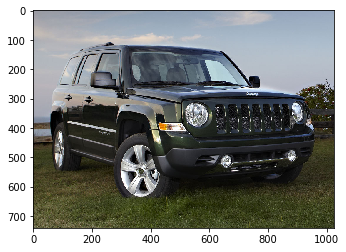

In [52]:
img = plt.imread(path_test_img+'00003.jpg')
plt.imshow(img)
print(classes.iloc[99])

In [54]:
test = torch.tensor([[1,2,3,4],
                    [6,7,5,3]])


In [55]:
_, y_index = torch.max(test, dim=1)
print(y_index)

tensor([3, 1])
